#A Marker of Fraud in Medicare Data
##Cluster Analysis and Outlier Detection in Provider Payment Data 

Medicare fraud accounts for between \$46 and \$58 Billion dollars, or 8 to 10 percent of total medicare expenditures, a year.  With the 2015 release of the CY 2013 medicare data, unsupervised learning techniques are implemented to look for paterns in which providers are billing for what procedures.  More specifically, an unsupervised clustering algorithm, k-means, is used to group similar data and identify outliers.  Most healthcare providers see somewhat similar patients and therefore will bill for roughly similar services.  This similarity allows for the clustering of those providers.  The resulting histogram of distances is extremely skewed.  Those providers who occupy the far tail of the range of distances are the outliers.  

In this analysis of Medicare Data, outright fraud is not being identified.  The outlier score is just a tool in a larger fraud investigation.  It is quite possible that a provider runs such a unique practice that they have no similar peers.  While this would label them an outlier, the jump to accusation of fraud can not be backed up.  



We need to set up the environment first.  NumPy, Pandas, and two SciKit-Learn packages are imported.

In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
# Set up some display settings to help view the large data set
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', 200)

## Data Preparation
We use the CY 2013 Medicare Provider Payment data that the Centers for Medicare and Medicaid services has provided.  You can find this data at https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Physician-and-Other-Supplier2013.html.  This data file is 1.7GB and contains over 9 million records.



In [52]:
data = pd.read_csv('Medicare_Provider_Util_Payment_PUF_CY2013.txt', sep='\t', skiprows={1}, 
                   usecols={'NPI', 'NPPES_ENTITY_CODE', 'HCPCS_CODE', 'PROVIDER_TYPE', 'HCPCS_DESCRIPTION', 
                            'LINE_SRVC_CNT', 'BENE_UNIQUE_CNT', 'BENE_DAY_SRVC_CNT'})


The dataset has one row per procedure code.  It provides the list of how many times this procedure code was billed for in the LINE_SRVC_CNT field.  The NPPES_ENTITY_CODE describes the type of provider.  "I" is used for an individual, "O" is used for other services, such as facilities and ambulance services.

In [53]:
print data[:1]

          NPI NPPES_ENTITY_CODE      PROVIDER_TYPE HCPCS_CODE    HCPCS_DESCRIPTION  LINE_SRVC_CNT  BENE_UNIQUE_CNT  \
0  1003000126                 I  Internal Medicine      99222  Initial hospital...            142              138   

   BENE_DAY_SRVC_CNT  
0                142  


The dataset contains individual providers as well as organizations.  In this analysis we are only looking to compare individual providers.  Also included is the provider type.  For this analysis I've chosen to only look at providers who self identify as "Internal Medicine".

In [54]:
data = data[(data.NPPES_ENTITY_CODE == 'I')]    
dataInternalMed = data[(data.PROVIDER_TYPE == "Internal Medicine")]

To aggregate this data into a provider based record instead of a procedure based record, a pivot table is built.  The resulting data is columns for each procedure code.  The cell value is the number of individual items billed. This pulls from the LINE_SRVC_CNT column of the origional data.

In [55]:
dataPivot = dataInternalMed.pivot_table('LINE_SRVC_CNT', ['NPI'], 'HCPCS_CODE')
dataMatrix = dataPivot.fillna(0)
print dataMatrix[:10]

HCPCS_CODE  00103  00104  00140  00142  00145  00300  00320  00400  00520  00530  ...    Q4102  Q9957  Q9960  Q9961  \
NPI                                                                               ...                                 
1003000126      0      0      0      0      0      0      0      0      0      0  ...        0      0      0      0   
1003000530      0      0      0      0      0      0      0      0      0      0  ...        0      0      0      0   
1003002312      0      0      0      0      0      0      0      0      0      0  ...        0      0      0      0   
1003002379      0      0      0      0      0      0      0      0      0      0  ...        0      0      0      0   
1003005836      0      0      0      0      0      0      0      0      0      0  ...        0      0      0      0   
1003006172      0      0      0      0      0      0      0      0      0      0  ...        0      0      0      0   
1003006503      0      0      0      0      0   

##Data Normalization

The pivot table is then normalized to better account for the various scales of each procedure billed.  This ensures that a popular procedure code is not overly weighted when computing the distances from the group center.

In [56]:
std_scale = preprocessing.StandardScaler().fit(dataMatrix)
dataMatrixNorm = std_scale.transform(dataMatrix)

## Optimizing for K
For a k-Means type algorithm, the value of k needs to be set for the algorithm.  The value of k represents the number of individual groups that are present in the data.  This data is difficult to determine and is usually estimated in unsupervised learning algorithms.  To assist with this, clusters are built with varying k values and the number of providers with a minimum distance of over 900 is printed.

In [57]:
results = pd.DataFrame(columns=['label','MinDistance','ClusterSize'])
print "Number of Clusters : Outliers Detected"
test_range = (i for j in (range(1,100, 20), range(100, 1000, 100)) for i in j)
for clusterSize in test_range:
    i_size = 3*clusterSize
    kmeans_model = MiniBatchKMeans(n_clusters=clusterSize, random_state=1, init_size=3*clusterSize).fit(dataMatrixNorm)
    labels = kmeans_model.labels_
    distances = kmeans_model.transform(dataMatrixNorm) 
    dataMatrix['label'] = labels
    mindist = np.amin(kmeans_model.transform(dataMatrixNorm), axis=1)
    dataMatrix['MinDistance'] = np.amin(kmeans_model.transform(dataMatrixNorm), axis=1)
    dataMatrix['ClusterSize'] = clusterSize
    dataMatrix['NPI'] = dataMatrix.index
    result = dataMatrix[['label','MinDistance','ClusterSize','NPI']]
    results = results.append(result[(result.MinDistance > 900)], ignore_index=True)
    print str(clusterSize) + ": " + str(dataMatrix[(dataMatrix.MinDistance > 900)]['label'].count())

Number of Clusters : Outliers Detected
1: 12
21: 12
41: 12
61: 12
81: 12
100: 12
200: 12
300: 12
400: 12
500: 10
600: 12
700: 12
800: 12
900: 12


Looking at each iteration of k, the number of detected outliers (those with a distance over 900 from the nearest group) remains relatively constant over the large range of k values. These outliers are significantly distanced from the bulk of providers. These same 12 providers appear in almost all values of k.

In [58]:
print "NPI Number       Occurances with distance over 900"
print results["NPI"].value_counts()

NPI Number       Occurances with distance over 900
1235322538    14
1043258270    14
1982813028    14
1114001914    14
1750364121    14
1558308239    14
1982668927    14
1669428645    14
1659530004    14
1477506657    14
1356303671    13
1295774594    13
dtype: int64


##Analysis of the Outliers
A k-value of 500 was chosen as the experimental value for k.  Any value in the range above could be subsituted without affecting the remaining analysis.

In [59]:
kmeans_model = MiniBatchKMeans(n_clusters=500, random_state=1, init_size=3*clusterSize).fit(dataMatrixNorm)
labels = kmeans_model.labels_
distances = kmeans_model.transform(dataMatrixNorm) 
dataMatrix['label'] = labels
mindist = np.amin(kmeans_model.transform(dataMatrixNorm), axis=1)
dataMatrix['MinDistance'] = np.amin(kmeans_model.transform(dataMatrixNorm), axis=1)
dataMatrix['ClusterSize'] = clusterSize
result = dataMatrix[['label','MinDistance','ClusterSize','NPI']]
print result["MinDistance"].describe()

count    93471.000000
mean        13.090744
std         43.195100
min          0.037124
25%          1.118158
50%          3.001815
75%          8.409991
max       1283.166404
Name: MinDistance, dtype: float64


Following the creation of the k-means model, the distribution of distances to the nearest group is shown below.

MinDistance
(0, 100]        91185
(100, 200]       1218
(200, 300]        488
(300, 400]        354
(400, 500]        111
(500, 600]         56
(600, 700]         24
(700, 800]         15
(800, 900]          8
(900, 1000]         5
(1000, 1100]        3
(1100, 1200]        1
(1200, 1300]        3
(1300, 1400]        0
Name: MinDistance, dtype: int64


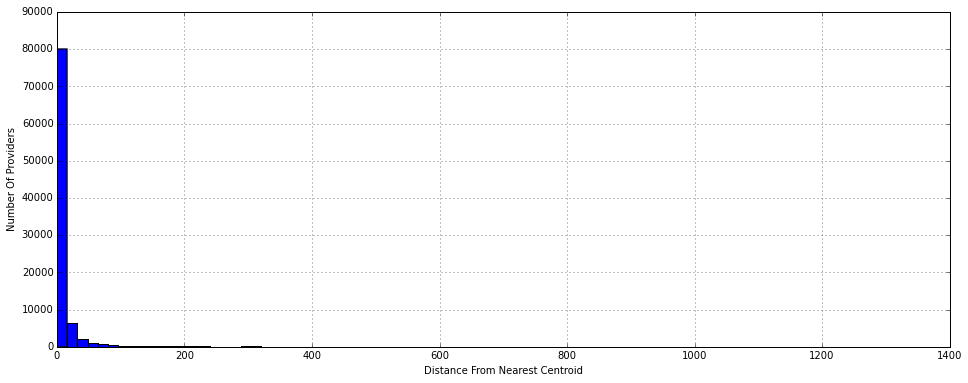

In [60]:
bins = np.linspace(0, 1400, 15)
groups = result.groupby(pd.cut(result.MinDistance, bins))
print groups.count().MinDistance
ax = result["MinDistance"].hist(bins=80, figsize=(16,6))
ax.set_xlabel("Distance From Nearest Centroid")
ax.set_ylabel("Number Of Providers")

97.54% of providers have a distance between a distance of 0 and 100.  To better view the providers that have distances above 100 units, the following histogram only plots providers that have a distance over 100.

The providers that have a distance over 900 represent the top 0.013% of all providers.

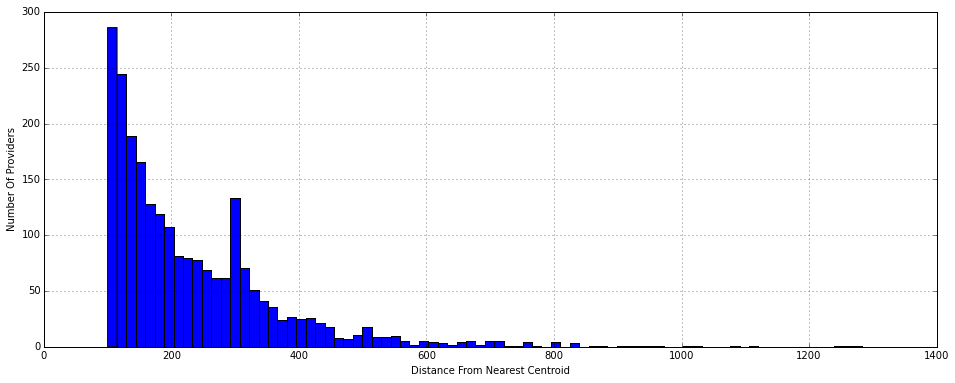

In [61]:
ax = result[(result.MinDistance > 100)]["MinDistance"].hist(bins=80, figsize=(16,6))
ax.set_xlabel("Distance From Nearest Centroid")
ax.set_ylabel("Number Of Providers")

##The Top Outlier

The top provider (NPI number 1982813028) has an interesting list of billed procedures.

In [62]:
pd.set_option('display.max_colwidth', 80)
result.sort(['MinDistance'], axis=0, ascending=False, inplace=True)
print dataInternalMed[(dataInternalMed.NPI == result.iloc[0]['NPI'])] \
    [["HCPCS_DESCRIPTION","LINE_SRVC_CNT","HCPCS_CODE"]].sort(["LINE_SRVC_CNT"], axis=0, ascending=False)

                                                                       HCPCS_DESCRIPTION  LINE_SRVC_CNT HCPCS_CODE
9179187                               Blood test, comprehensive group of blood chemicals          57976      80053
9179268  Complete blood cell count (red cells, white blood cell, platelets), automate...          46212      85025
9179188                               Blood test, lipids (cholesterol and triglycerides)          44942      80061
9179254                                    Blood test, thyroid stimulating hormone (TSH)          31488      84443
9179227                                                             Hemoglobin A1C level          24125      83036
9179194                         Manual urinalysis test with examination using microscope          16712      81001
9179185                                       Blood test, basic group of blood chemicals          11717      80048
9179204                                                                Vitamin D

The provider has billed for 157665ml (41.6 Gallons) of contrast material in CY 2013.  Interestingly enough, the amount this provider billed for is 7.5% of this specific contrast out of all providers.

In [63]:
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "Q9967")]["LINE_SRVC_CNT"].describe()
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "Q9967")]["LINE_SRVC_CNT"].sum()

count       465.000000
mean       4519.752688
std       10903.446531
min          13.000000
25%        1380.000000
50%        1975.000000
75%        3430.000000
max      157665.000000
Name: LINE_SRVC_CNT, dtype: float64
2101685.0


The next highest non-office visit billing for this physician was for Thallium tl-201. As with the contrast, this particular billing is significanly higher than the other providers.  The total billed 4076 millicurie amount accounts for 12.7% of all uses.

In [64]:
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "A9505")]["LINE_SRVC_CNT"].describe()
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "A9505")]["LINE_SRVC_CNT"].sum()

count     115.000000
mean      277.173913
std       554.783793
min        11.000000
25%        60.000000
50%       101.000000
75%       256.000000
max      4076.000000
Name: LINE_SRVC_CNT, dtype: float64
31875.0


##The Second Outlier
An examination of the second highest provider also shows significant departures from an average provider.  The top two procedures that this provider billed to Medicare are an Opiate Drug Measurement (HCPCS 83925) and Mephedrone and MDPV Bath Salts Urine Test Kit (HCPCS 82542).  Both of these procedures are not billed often.  

In [65]:
dataInternalMed[(dataInternalMed.NPI == result.iloc[1]['NPI'])] \
    [["HCPCS_DESCRIPTION","LINE_SRVC_CNT","HCPCS_CODE"]].sort(["LINE_SRVC_CNT"], axis=0, ascending=False)

,HCPCS_DESCRIPTION,LINE_SRVC_CNT,HCPCS_CODE
7001873,Opiates (drug) measurement,18651.4,83925
7001866,Chemical analysis using chromatography technique,10358.0,82542
7001882,"Established patient office or other outpatient visit, typically 15 minutes",4724.0,99213
7001861,Analysis of urine,4395.0,81005
7001874,Body fluid pH level,4391.0,83986
7001867,Creatinine level to test for kidney function or muscle injury,4380.0,82570
7001885,"Drug screen, qualitative; multiple drug classes by high complexity test meth...",4266.0,G0431
7001870,Mass spectrometry (laboratory testing method),4247.0,83789
7001862,Alcohol (ethanol) level,4199.0,82055
7001869,Dihydromorphinone (drug) level,3758.0,82649


Opiate Drug Screen Test

In [66]:
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "83925")]["LINE_SRVC_CNT"].describe()
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "83925")]["LINE_SRVC_CNT"].sum()

count       22.000000
mean      1744.290909
std       4307.779850
min         13.000000
25%         89.500000
50%        227.000000
75%        966.250000
max      18651.400000
Name: LINE_SRVC_CNT, dtype: float64
38374.4


Bath Salt Test

In [67]:
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "82542")]["LINE_SRVC_CNT"].describe()
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "82542")]["LINE_SRVC_CNT"].sum()

count        4.000000
mean      2610.000000
std       5165.342648
min         15.000000
25%         24.750000
50%         33.500000
75%       2618.750000
max      10358.000000
Name: LINE_SRVC_CNT, dtype: float64
10440.0


##The Number Three Provider
The third highest provider also has interesting individual billing items.  The most frequently billed procedure is a CBC blood test.  While this test is frequently preformed (6,828 providers billed for this procedure), the quantity billed was unusual.  This provider has billed for a CBC blood test the most out of all providers, a total of 57,976 times in CY2013.  This provider’s billing of 16,712 individual manual urinalysis tests (HCPCS Code 81001) is also the top amount for all providers.  The mean items billed by those providers who had billed for this code was 133.  There is significant departure from the mean of this providers billing.

In [68]:
dataInternalMed[(dataInternalMed.NPI == result.iloc[2]['NPI'])] \
    [["HCPCS_DESCRIPTION","LINE_SRVC_CNT","HCPCS_CODE"]].sort(["LINE_SRVC_CNT"], axis=0, ascending=False)


,HCPCS_DESCRIPTION,LINE_SRVC_CNT,HCPCS_CODE
2748609,"Low osmolar contrast material, 300-399 mg/ml iodine concentration, per ml",157665,Q9967
2748585,"Established patient office or other outpatient visit, typically 15 minutes",6258,99213
2748586,"Established patient office or other outpatient, visit typically 25 minutes",4111,99214
2748593,"Thallium tl-201 thallous chloride, diagnostic, per millicurie",4076,A9505
2748494,Insertion of needle into vein for collection of blood sample,3741,36415
2748589,"Subsequent hospital inpatient care, typically 25 minutes per day",3523,99232
2748602,"Injection, methylprednisolone acetate, 20 mg",3320,J1020
2748554,"Complete blood cell count (red cells, white blood cell, platelets), automate...",2871,85025
2748548,"Blood test, lipids (cholesterol and triglycerides)",2857,80061
2748553,"Blood test, thyroid stimulating hormone (TSH)",2784,84443


In [69]:
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "80053")]["LINE_SRVC_CNT"].describe()
print "NPI for the highest biller of 80053(Blood Test)"
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "80053") & (dataInternalMed.LINE_SRVC_CNT == 57976)]["NPI"] \
    .to_string()

count     6828.000000
mean       378.339924
std        856.587351
min         11.000000
25%         94.750000
50%        258.000000
75%        501.000000
max      57976.000000
Name: LINE_SRVC_CNT, dtype: float64
NPI for the highest biller of 80053(Blood Test)
9179187    1982813028


In [70]:
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "81001")]["LINE_SRVC_CNT"].describe()
print dataInternalMed[(dataInternalMed.HCPCS_CODE == "81001")]["LINE_SRVC_CNT"].sum()

count     4332.000000
mean       133.136427
std        302.590268
min         11.000000
25%         31.000000
50%         69.500000
75%        161.000000
max      16712.000000
Name: LINE_SRVC_CNT, dtype: float64
576747.0


Unsupervised clustering algorithms are often hindered by the curse of dimensionality.  As the number of dimensions grow, the distance between data points often shrinks.  At the apex of this, every data point is sufficently distant from any other point.  In this analysis, the 2,239 dimensions, or features, are able to produce meaningful grouping of providers.  

#Finding Outliers in Categorical Data

The previous model looked for outliers that differentiated on individual HCPCS procedure codes.  There were 2,239 codes that were billed by Internal Medicine providers in CY 2013.  Many of these codes are similar to each other.  In order to identify outliers in types of billing, these 2,239 codes are grouped into categories.

The Healthcare Cost and Utilization Project has created the Clinical Classification Software for Services and Procedures (CCS) (https://www.hcup-us.ahrq.gov/toolssoftware/ccs_svcsproc/ccssvcproc.jsp).  The CCS groups over 9,000 HCPCS codes into 224 clinically meaningful categories.   Due to legal restrictions, only ranges of HCPCS codes are able to be provided.  These ranges are expanded and then appended to the rows of billed procedures.

In [71]:
categories = pd.read_csv('./2015_ccs_services_procedures.csv', skiprows={0})
categories.columns = ['codeRange', 'ccs', 'desc']
ccsTable = pd.DataFrame()

def outputCCSConversion(r):
    global ccsTable   
    codeStart = r.codeRange[1:6]
    codeEnd = r.codeRange[7:12] 
    if codeStart.isdigit() and codeEnd.isdigit():
        for i in range(int(codeStart),int(codeEnd) + 1):
            ccsTable = ccsTable.append([{'ccs': r.ccs, 'cpt': str(i).zfill(5)}])
    elif not codeStart[0:1].isdigit():
        for i in range(int(codeStart[1:5]),int(codeEnd[1:5]) + 1):
            ccsTable = ccsTable.append([{'ccs': r.ccs, 'cpt': codeStart[0:1] + str(i).zfill(4)}])
    elif not codeStart[4:5].isdigit():
        for i in range(int(codeStart[0:4]),int(codeEnd[0:4]) + 1):
            ccsTable = ccsTable.append([{'ccs': r.ccs, 'cpt': str(i).zfill(4) + codeStart[4:5]}])


categories.apply(outputCCSConversion, axis=1);


In [72]:
dataInternalMedCCS = pd.merge(dataInternalMed,ccsTable, left_on='HCPCS_CODE', right_on='cpt')
dataInternalMedCCS.sort(['NPI'], axis=0, ascending=False, inplace=True)

As above the value k is optimized but this time using a distance value of 350.  Due to the grouping of procedure codes, it is expected that the distances would be less overall.

In [73]:

dataPivot = dataInternalMedCCS.pivot_table('LINE_SRVC_CNT', ['NPI'], 'ccs')
dataMatrix = dataPivot.fillna(0)
std_scale = preprocessing.StandardScaler().fit(dataMatrix)
dataMatrixNorm = std_scale.transform(dataMatrix)
results = pd.DataFrame(columns=['label','MinDistance','ClusterSize'])
print "Number of Clusters : Outliers Detected"
test_range = (i for j in (range(1,100, 20), range(100, 1000, 100)) for i in j)
for clusterSize in test_range:
    i_size = 3*clusterSize
    kmeans_model = MiniBatchKMeans(n_clusters=clusterSize, random_state=1, init_size=3*clusterSize).fit(dataMatrixNorm)
    labels = kmeans_model.labels_
    distances = kmeans_model.transform(dataMatrixNorm) 
    dataMatrix['label'] = labels
    mindist = np.amin(kmeans_model.transform(dataMatrixNorm), axis=1)
    dataMatrix['MinDistance'] = np.amin(kmeans_model.transform(dataMatrixNorm), axis=1)
    dataMatrix['ClusterSize'] = clusterSize
    dataMatrix['NPI'] = dataMatrix.index
    result = dataMatrix[['label','MinDistance','ClusterSize','NPI']]
    results = results.append(result[(result.MinDistance > 350)], ignore_index=True)
    print str(clusterSize) + ": " + str(dataMatrix[(dataMatrix.MinDistance > 350)]['label'].count())
    

Number of Clusters : Outliers Detected
1: 9
21: 9
41: 8
61: 9
81: 9
100: 9
200: 9
300: 8
400: 9
500: 8
600: 9
700: 7
800: 7
900: 8


Using a distance value of 350 as the cutoff for an outlier, a similar number of outliers is present.  The distribution of providers looks similar to the distribution above.

MinDistance
(0, 50]       92661
(50, 100]       219
(100, 150]       83
(150, 200]       34
(200, 250]       20
(250, 300]       12
(300, 350]       17
(350, 400]        3
(400, 450]        2
(450, 500]        1
(500, 550]        2
(550, 600]        0
Name: MinDistance, dtype: int64


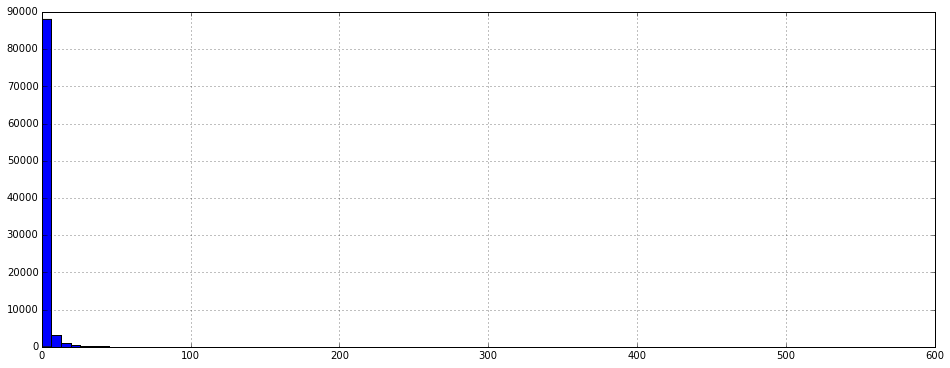

In [74]:
bins = np.linspace(0, 600, 13)
groups = result.groupby(pd.cut(result.MinDistance, bins))
print groups.count().MinDistance
result["MinDistance"].hist(bins=80, figsize=(16,6))

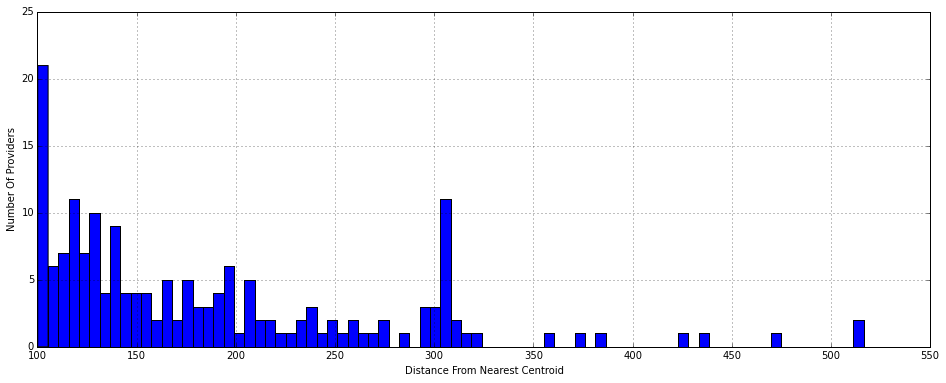

In [75]:
ax = result[(result.MinDistance > 100)]["MinDistance"].hist(bins=80, figsize=(16,6))
ax.set_xlabel("Distance From Nearest Centroid")
ax.set_ylabel("Number Of Providers")

##Top Outlier
The On the surface, it is obvious that the top categorical outlier is different from the average internal medicine provider.  Five of the billing line items present are for surgical procedures.  The remaining is a mix of diagnostic imaging and office visits.

In [76]:
result.sort(['MinDistance'], axis=0, ascending=False, inplace=True)
dataInternalMedCCS[(dataInternalMedCCS.NPI == result.iloc[0]['NPI'])] \
    [["HCPCS_DESCRIPTION","LINE_SRVC_CNT","HCPCS_CODE","ccs"]].sort(["LINE_SRVC_CNT"], axis=0, ascending=False)

,HCPCS_DESCRIPTION,LINE_SRVC_CNT,HCPCS_CODE,ccs
905534,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg",1260,J3301,240
302141,"Established patient office or other outpatient visit, typically 15 minutes",389,99213,227
475506,Aspiration or injection of large joint or joint capsule,329,20610,155
642766,"New patient office or other outpatient visit, typically 30 minutes",205,99203,227
1126257,"X-ray of knee, 3 views",203,73562,226
1155257,"X-ray of shoulder, minimum of 2 views",120,73030,226
550198,"Established patient office or other outpatient visit, typically 10 minutes",57,99212,227
1153783,MRI scan of leg joint,44,73721,198
1171664,MRI scan of arm joint arm joint,30,73221,198
1187074,Removal of one knee cartilage using an endoscope,29,29881,151


##Second Outlier
The second and third categorical outliers also have numerous surgical and diagnostic imaging HCPCS codes.  These top three categorical outliers show a significant difference from the their outliers that were identified using HCPCS codes.  These providers most likely have either outdated or incorrect self reported practice types.

In [77]:
dataInternalMedCCS[(dataInternalMedCCS.NPI == result.iloc[1]['NPI'])] \
    [["HCPCS_DESCRIPTION","LINE_SRVC_CNT","HCPCS_CODE","ccs"]].sort(["LINE_SRVC_CNT"], axis=0, ascending=False)

,HCPCS_DESCRIPTION,LINE_SRVC_CNT,HCPCS_CODE,ccs
730631,"X-ray of lower and sacral spine, 2 or 3 views",234,72100,226
560226,"Established patient office or other outpatient visit, typically 10 minutes",212,99212,227
333066,"Established patient office or other outpatient visit, typically 15 minutes",168,99213,227
494432,"New patient office or other outpatient visit, typically 45 minutes",126,99204,227
1186998,Insertion of spinal instrumentation for spinal stabilization,114,22851,158
1164038,"X-ray of spine, 3 views or less",111,72040,226
1189869,Donor bone graft for spine surgery,72,20931,161
879132,"New patient office or other outpatient visit, typically 60 minutes",59,99205,227
649074,"New patient office or other outpatient visit, typically 30 minutes",53,99203,227
389844,"Established patient office or other outpatient, visit typically 25 minutes",42,99214,227


##Third Outlier

In [78]:
result.sort(['MinDistance'], axis=0, ascending=False, inplace=True)
dataInternalMedCCS[(dataInternalMedCCS.NPI == result.iloc[3]['NPI'])] \
    [["HCPCS_DESCRIPTION","LINE_SRVC_CNT","HCPCS_CODE","ccs"]].sort(["LINE_SRVC_CNT"], axis=0, ascending=False)

,HCPCS_DESCRIPTION,LINE_SRVC_CNT,HCPCS_CODE,ccs
511125,"Established patient office or other outpatient, visit typically 40 minutes",82,99215,227
1189621,Internal shock to heart to regulate heart beat,75,92961,49
1189617,Repair of heart valve between right chambers with insertion of prosthetic va...,75,33464,43
378842,"Established patient office or other outpatient, visit typically 25 minutes",50,99214,227
1189616,Repair of valve flaps between left heart chambers on heart-lung machine,49,33427,43
1189615,Insertion of artificial valve between left heart chambers on heart-lung machine,40,33426,43
279271,Routine EKG using at least 12 leads including interpretation and report,40,93000,202
1189613,Destruction of tissue and reconstruction of right upper heart on heart-lung ...,38,33259,49
1189614,Replacement of left lower heart chamber valve using artificial valve on hear...,27,33405,43
1189619,Reoperation of heart artery bypass or valve procedure,14,33530,44


The top three outliers show that although the providers self identified as Internal Medicine, these three providers are not typical.  Most likely the first two outliers are surgeons, and the third outlier is most likely a Cardiologist/Cardiac Surgeon.

## Conclusion
Fraud detection is a complex process that relies on numerous inputs.  This outlier score does not determine whether or not a provider is committing fraud.  This score can be used to evaluate how similar a provider is to their peers.  A high outlier score shows that based on a provider’s billed items, they are different from their peers.  While this can be a valuable tool in an overall assessment of fraud risk, it is not a panacea.  Furthermore, traditional fraud detection methods rely on training data sets that contain both known fraudulent records as well as non-fraudulent records.  This classification type problem is typically solved utilizing a supervised learning algorithm.  Using this approach for detecting healthcare fraud will require a set of known fraudulent records.  The unsupervised algorithm used here does not rely on known fraudulent records.  This allows for exploration of potentially fraudulent providers without the need to develop a classification algorithm.  The algorithm has successfully identified providers whose billing items are significantly different from their peers. 